**<h2> MADS: Milestone II (Team 10) - Learning Curve for all supervised models</h2>**
<h3> Topic: Machine learning on duty: solving consumer complaints and improving satisfaction!</h3>
<h4> Authors: Chih-Han Yeh (yehch), Yi-Hsin Chien (yihsinc), Weiming Chen ( weimingc) </h4>
<h4> Mentor: Alexis Castellanos</h4>

#Environment Setting
Importing libraries we need for our project.

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
!pip install keras
!pip install catboost

In [16]:
!pip install scikeras[tensorflow]
!pip install scikit-optimize

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn import metrics
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
# Built-in libraries
import re
import string
import warnings

# Third-party libraries for data handling and processing
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm import tqdm

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import KeyedVectors

# Pre-processing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, MaxAbsScaler
from imblearn.over_sampling import SMOTE

# Model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Machine Learning Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Deep Learning Libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, LSTM
from keras.callbacks import EarlyStopping

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt


# Miscellaneous
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tqdm.pandas()
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Loading preprocessed dataset for saving computing power


In [18]:
y = pd.read_hdf('/content/drive/MyDrive/milestone II/y.h5', key='y_p')

In [19]:
X = pd.read_hdf('/content/drive/MyDrive/milestone II/X.h5', key='X_p')

#Supervised models: Logistic Regression, Naive Bayes, LightGBM, XGB, Catboost, ANN

In [24]:
# train with logistic regression and do cross-validation, wrap in a function
def cross_val_lr(X_smote, y_smote, k):

    # Define a pipeline consisting of preprocessing and model
    pipe = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression(max_iter=1000, random_state=42))])

    # Perform 5-fold cross-validation with the pipeline
    scores = cross_val_score(pipe, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    # print(f"Mean score of cross validation: {scores.mean()}")
    # return scores.mean()
    return scores.mean(), scores.std()


# train naive bayes and do cross-validation

def cross_val_naive_bayes(X_smote, y_smote, k):

    # Define a pipeline consisting of preprocessing and model
    # scale values as nb not working with negative
    pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(pipe, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    # print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean(), scores.std()

# train lightgbm and do cross-validation

def cross_val_lgbm(X_smote, y_smote, k):

    # instantiate lightgbm model
    classifier = LGBMClassifier(random_state=42)

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    # print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean(), scores.std()

# train with xgboost

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Starting in XGBoost")

def cross_val_xgb(X_smote, y_smote, k):

    # instantiate xgboost model
    classifier = XGBClassifier(random_state=42, n_jobs=-1)

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    # print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean(), scores.std()


# catboost in a function

def cross_val_catboost(X_smote, y_smote, k):

    # instantiate catboost model
    classifier = CatBoostClassifier(random_state=42)

    # Perform 5-fold cross-validation and get scores
    scores = cross_val_score(classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")

    # print f1 score
    # print(f"Mean score of cross validation: {scores.mean()}")

    return scores.mean(), scores.std()


# train ann

def create_ann_model(X_smote):

    # instantiate ann model
    ann = Sequential()

    # add input layer
    ann.add(Dense(128, activation='relu', input_shape=(X_smote.shape[1],)))

    # add hidden layers
    ann.add(Dense(64, activation='relu'))
    ann.add(Dense(32, activation='relu'))
    ann.add(Dense(16, activation='relu'))

    # add output layer
    ann.add(Dense(1, activation='sigmoid'))

    # compile model
    ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return ann

def cross_val_ann(X_smote, y_smote, k):
    # train ann
    model_ann = create_ann_model(X_smote)

    # Instantiate KerasClassifier with ANN model creation function
    ann_classifier = KerasClassifier(build_fn=create_ann_model(X_smote), epochs=10, batch_size=32, verbose=0)

    # conduct cross validation and get scores
    scores = cross_val_score(ann_classifier, X_smote, y_smote, cv=k, scoring = "f1_macro")
    return scores.mean(), scores.std()

The data was processed using varying percentages to illustrate the learning curve. This exercise aimed to assess the computational capacity of the Colab environment. To avoid unexpected system crashes, we run each portion individually. For subsequent models, we generally employed a for-loop. Nevertheless, the approach varied depending on the memory needs of each model configuration. For instance, the Naive Bayes model demanded less RAM than others, allowing us to use a for-loop and obtain results in a single run. In contrast, more resource-intensive models like XGB required the tasks to be split into multiple segments due to computational limitations.






*   Logistic Regression



In [ ]:
frac = np.linspace(0.1, 1.0, 10).tolist()
meanss =[]
stdss = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_lr(Xt, yt, 5)
  meanss.append(m)
  stdss.append(s)

In [ ]:
#backup for the results
dict = {
    '10%': [0.61530044, 0.60532613, 0.62123947, 0.62965822, 0.60260488],
    '20%': [0.62211966, 0.63280677, 0.618975,   0.61941278, 0.63164234],
    '30%': [0.62934005, 0.63011767, 0.62658928, 0.62825434, 0.62845739],
    '40%': [0.63500401, 0.62888894, 0.62954969, 0.63531877, 0.62261436],
'50%': [0.63625881, 0.63187728, 0.6330952,  0.62790436, 0.63305241],
    '60%': [0.63546285, 0.63282655, 0.63333258, 0.63125097, 0.63701516],
        '70%': [0.63784047, 0.63592449, 0.63248451, 0.63452465, 0.64015692],
      '80%': [0.63774864, 0.63825648, 0.63336928, 0.63888516, 0.63943981],
      '90%': [0.63952065, 0.63586006, 0.63580354, 0.64212863, 0.63860512],
      '100%': [0.6063656 , 0.62343408, 0.64154385, 0.65325772, 0.64865349]
}
dd = pd.DataFrame(dict).T


,0,1,2,3,4,mean,std
10%,0.615300,0.605326,0.621239,0.629658,0.602605,0.614826,0.010010
20%,0.622120,0.632807,0.618975,0.619413,0.631642,0.624991,0.006015
30%,0.629340,0.630118,0.626589,0.628254,0.628457,0.628552,0.001185
40%,0.635004,0.628889,0.629550,0.635319,0.622614,0.630275,0.004668
50%,0.636259,0.631877,0.633095,0.627904,0.633052,0.632438,0.002694
60%,0.635463,0.632827,0.633333,0.631251,0.637015,0.633978,0.002030
70%,0.637840,0.635924,0.632485,0.634525,0.640157,0.636186,0.002647
80%,0.637749,0.638256,0.633369,0.638885,0.639440,0.637540,0.002162
90%,0.639521,0.635860,0.635804,0.642129,0.638605,0.638384,0.002383
100%,0.606366,0.623434,0.641544,0.653258,0.648653,0.634651,0.017411


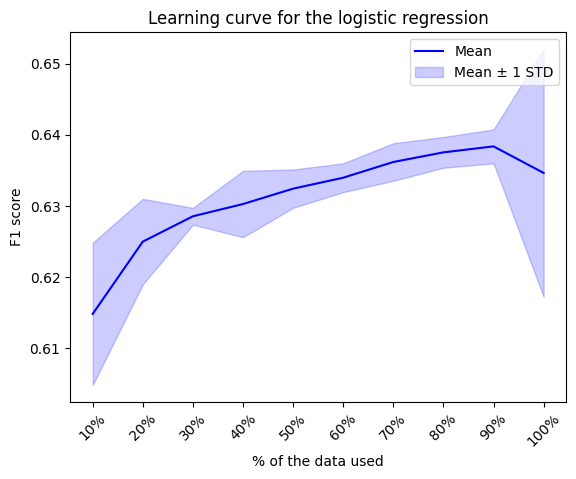

In [ ]:
x = range(len(meanss))

# plot the mean line
plt.plot(x, meanss, color='blue', label='Mean')

# ±1 std region filled
plt.fill_between(x, np.array(meanss) - np.array(stdss), np.array(meanss) + np.array(stdss), color='blue', alpha=0.2, label='Mean ± 1 STD')

plt.legend()
plt.title('Learning curve for the logistic regression')
plt.xlabel('% of the data used')
plt.ylabel('F1 score')
xticks_positions = np.linspace(0, 9, 10)
xticks_labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.show()



*   Naive Bayes



In [ ]:
frac = np.linspace(0.1, 1.0, 10).tolist()
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_naive_bayes(Xt, yt, 5)
  means.append(m)
  stds.append(s)


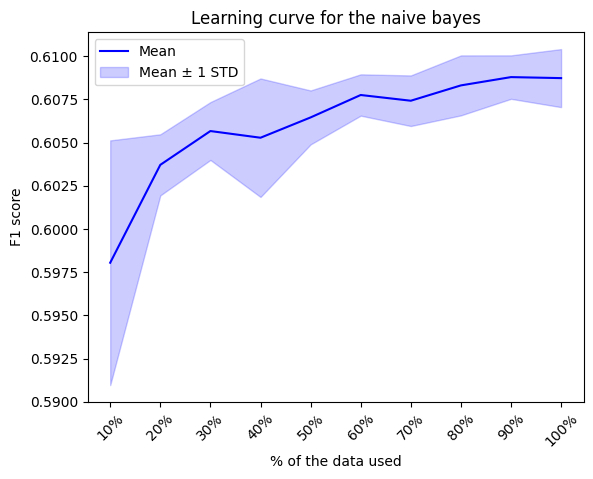

In [ ]:

x = range(len(means))

# plot mean line
plt.plot(x, means, color='blue', label='Mean')

# ±1 std region filled with color
plt.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2, label='Mean ± 1 STD')

plt.legend()
plt.title('Learning curve for the naive bayes')
plt.xlabel('% of the data used')
plt.ylabel('F1 score')
xticks_positions = np.linspace(0, 9, 10)
xticks_labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.show()



*   LightGBM



In [ ]:
frac = np.linspace(0.1, 1.0, 10).tolist()
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_lgbm(Xt, yt, 5)
  means.append(m)
  stds.append(s)

[LightGBM] [Info] Number of positive: 10257, number of negative: 10207
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83188
[LightGBM] [Info] Number of data points in the train set: 20464, number of used features: 571
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501222 -> initscore=0.004887
[LightGBM] [Info] Start training from score 0.004887
[LightGBM] [Info] Number of positive: 10257, number of negative: 10208
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 83186
[LightGBM] [Info] Number of data points in the train set: 20465, number of used features: 569
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501197 -> initscore=0.004789
[LightGBM] [Info] Start training from score 0.004789
[Light

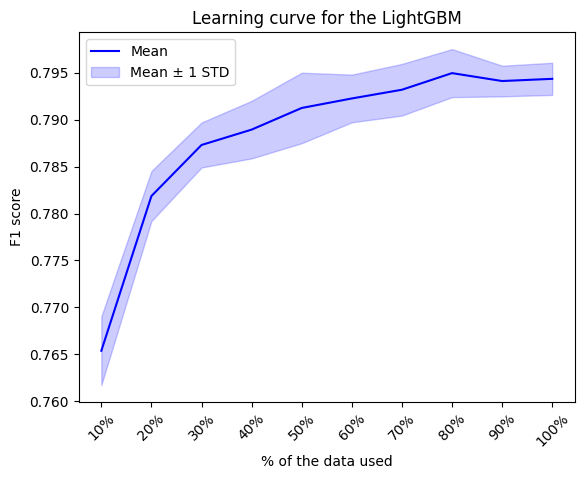

In [ ]:

x = range(len(means))

# plot mean line
plt.plot(x, means, color='blue', label='Mean')

# ±1 std regioin filled with color
plt.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2, label='Mean ± 1 STD')

plt.legend()
plt.title('Learning curve for the LightGBM')
plt.xlabel('% of the data used')
plt.ylabel('F1 score')
xticks_positions = np.linspace(0, 9, 10)
xticks_labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.show()



*   XGB



In [8]:
frac = [0.1,0.2,0.3,0.4,0.5]
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_xgb(Xt, yt, 5)
  means.append(m)
  stds.append(s)
  print(means)
  print(stds)

[0.758404383689492]
[0.005235304549762033]
[0.758404383689492, 0.7802654118305538]
[0.005235304549762033, 0.0042457055382485055]
[0.758404383689492, 0.7802654118305538, 0.7876736572183883]
[0.005235304549762033, 0.0042457055382485055, 0.002984811845745431]
[0.758404383689492, 0.7802654118305538, 0.7876736572183883, 0.7904252951412429]
[0.005235304549762033, 0.0042457055382485055, 0.002984811845745431, 0.003417627802965071]
[0.758404383689492, 0.7802654118305538, 0.7876736572183883, 0.7904252951412429, 0.7931504256056452]
[0.005235304549762033, 0.0042457055382485055, 0.002984811845745431, 0.003417627802965071, 0.0029033591263420535]


In [ ]:
frac = [0.6]
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_xgb(Xt, yt, 5)
  means.append(m)
  stds.append(s)
  print(means)
  print(stds)

[0.758404383689492, 0.7802654118305538, 0.7876736572183883, 0.7904252951412429, 0.7931504256056452, 0.794141410399517]
[0.005235304549762033, 0.0042457055382485055, 0.002984811845745431, 0.003417627802965071, 0.0029033591263420535, 0.0031176870973742567]


In [ ]:
frac = [0.7]
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_xgb(Xt, yt, 5)
  means.append(m)
  stds.append(s)
  print(means)
  print(stds)

[0.7949750593615945]
[0.0024199042751826094]


In [ ]:
frac = [0.8,0.9]
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_xgb(Xt, yt, 5)
  means.append(m)
  stds.append(s)
  print(means)
  print(stds)

[0.7959426492904208]
[0.002525495120462525]
[0.7959426492904208, 0.796894871805913]
[0.002525495120462525, 0.0020198958173028693]


In [8]:
frac = [1.0]
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_xgb(Xt, yt, 5)
  means.append(m)
  stds.append(s)
  print(means)
  print(stds)

[0.7971578046670377]
[0.002144724618118641]


[0.758404383689492, 0.7802654118305538, 0.7876736572183883, 0.7904252951412429, 0.7931504256056452, 0.794141410399517, 0.7949750593615945, 0.7959426492904208, 0.796894871805913, 0.7971578046670377]
[0.005235304549762033, 0.0042457055382485055, 0.002984811845745431, 0.003417627802965071, 0.0029033591263420535, 0.0031176870973742567, 0.0024199042751826094, 0.002525495120462525, 0.0020198958173028693, 0.002144724618118641]


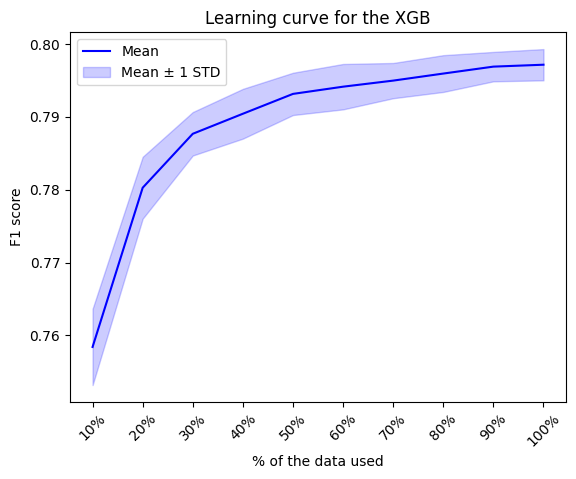

In [11]:
means = [0.758404383689492, 0.7802654118305538, 0.7876736572183883, 0.7904252951412429, 0.7931504256056452, 0.794141410399517, 0.7949750593615945,0.7959426492904208, 0.796894871805913,0.7971578046670377]
stds = [0.005235304549762033, 0.0042457055382485055, 0.002984811845745431, 0.003417627802965071, 0.0029033591263420535, 0.0031176870973742567,0.0024199042751826094,0.002525495120462525, 0.0020198958173028693,0.002144724618118641]
print(means)
print(stds)
x = range(len(means))

# plot mean line
plt.plot(x, means, color='blue', label='Mean')

# ±1 std region filled with color
plt.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2, label='Mean ± 1 STD')

plt.legend()
plt.title('Learning curve for the XGB')
plt.xlabel('% of the data used')
plt.ylabel('F1 score')
xticks_positions = np.linspace(0, 9, 10)
xticks_labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.show()



*   Catboost


In [12]:
frac = np.linspace(0.1, 1.0, 10).tolist()
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_catboost(Xt, yt, 5)
  means.append(m)
  stds.append(s)

串流輸出內容已截斷至最後 5000 行。
4:	learn: 0.6575807	total: 465ms	remaining: 1m 32s
5:	learn: 0.6533223	total: 557ms	remaining: 1m 32s
6:	learn: 0.6493554	total: 652ms	remaining: 1m 32s
7:	learn: 0.6435670	total: 748ms	remaining: 1m 32s
8:	learn: 0.6404875	total: 832ms	remaining: 1m 31s
9:	learn: 0.6377300	total: 917ms	remaining: 1m 30s
10:	learn: 0.6351504	total: 1s	remaining: 1m 29s
11:	learn: 0.6327775	total: 1.08s	remaining: 1m 29s
12:	learn: 0.6302516	total: 1.17s	remaining: 1m 28s
13:	learn: 0.6280602	total: 1.25s	remaining: 1m 28s
14:	learn: 0.6259546	total: 1.34s	remaining: 1m 27s
15:	learn: 0.6239187	total: 1.43s	remaining: 1m 27s
16:	learn: 0.6216192	total: 1.5s	remaining: 1m 26s
17:	learn: 0.6199503	total: 1.59s	remaining: 1m 26s
18:	learn: 0.6181991	total: 1.67s	remaining: 1m 26s
19:	learn: 0.6165234	total: 1.75s	remaining: 1m 25s
20:	learn: 0.6136393	total: 1.83s	remaining: 1m 25s
21:	learn: 0.6118005	total: 1.92s	remaining: 1m 25s
22:	learn: 0.6103542	total: 2s	remaining: 1m 24s
23:	

[0.7793144609885783, 0.7986909137927661, 0.8047810545915611, 0.8083426803523744, 0.8116756185829954, 0.8140283296704265, 0.8159374261952888, 0.817555737417645, 0.8190691658809325, 0.8200080098253041]
[0.0036619009160908417, 0.0036562549203112238, 0.0026273236035599624, 0.003520056328399345, 0.004261297499305215, 0.0030555888801601285, 0.0027934863468270297, 0.0011277193007808637, 0.0017741360749538167, 0.0020294176317734126]


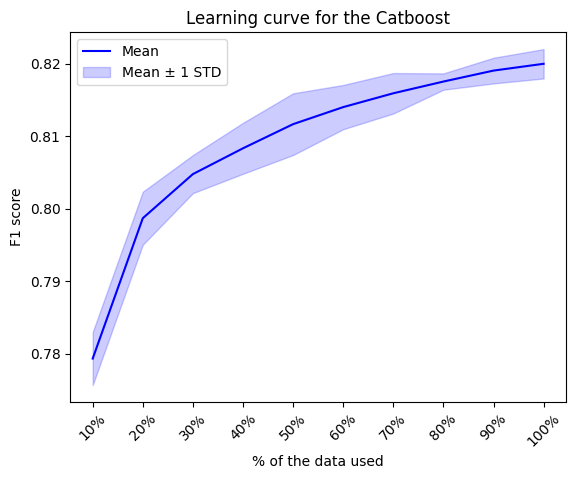

In [22]:
means = [0.7793144609885783, 0.7986909137927661, 0.8047810545915611, 0.8083426803523744, 0.8116756185829954, 0.8140283296704265, 0.8159374261952888, 0.817555737417645, 0.8190691658809325, 0.8200080098253041]
stds = [0.0036619009160908417, 0.0036562549203112238, 0.0026273236035599624, 0.003520056328399345, 0.004261297499305215, 0.0030555888801601285, 0.0027934863468270297, 0.0011277193007808637, 0.0017741360749538167, 0.0020294176317734126]
print(means)
print(stds)
x = range(len(means))

# plot mean line
plt.plot(x, means, color='blue', label='Mean')

# ±1 std region filled with color
plt.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2, label='Mean ± 1 STD')

plt.legend()
plt.title('Learning curve for the Catboost')
plt.xlabel('% of the data used')
plt.ylabel('F1 score')
xticks_positions = np.linspace(0, 9, 10)
xticks_labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.show()



*   ANN



In [25]:
frac = np.linspace(0.1, 1.0, 10).tolist()
means =[]
stds = []
for f in frac:
  Xt= X.sample(frac=f, random_state = 42)
  yt = y.sample(frac=f, random_state = 42)
  m, s = cross_val_ann(Xt, yt, 5)
  print(means)
  print(stds)
  means.append(m)
  stds.append(s)

[]
[]
[0.6790991316616244]
[0.00905848984445046]


[0.6790991316616244, 0.7067313735132863]
[0.00905848984445046, 0.009382777991505492]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517, 0.7545674121938297]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995, 0.005908903945027859]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517, 0.7545674121938297, 0.7634823777383825]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995, 0.005908903945027859, 0.0020633005403140376]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517, 0.7545674121938297, 0.7634823777383825, 0.7676438127649987]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995, 0.005908903945027859, 0.0020633005403140376, 0.0030330887741148]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517, 0.7545674121938297, 0.7634823777383825, 0.7676438127649987, 0.7760654860025824]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995, 0.005908903945027859, 0.0020633005403140376, 0.0030330887741148, 0.0057622782398070345]


[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517, 0.7545674121938297, 0.7634823777383825, 0.7676438127649987, 0.7760654860025824, 0.7804004651280898]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995, 0.005908903945027859, 0.0020633005403140376, 0.0030330887741148, 0.0057622782398070345, 0.0028826473069366526]


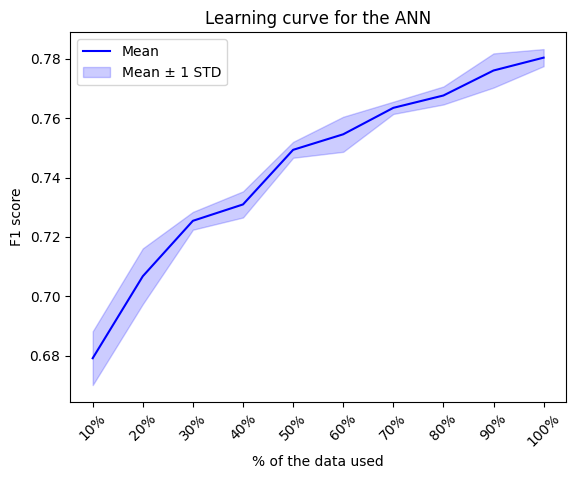

In [27]:
print(means)
print(stds)
x = range(len(means))

# plot mean line
plt.plot(x, means, color='blue', label='Mean')

# ±1 std region filled with color
plt.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds), color='blue', alpha=0.2, label='Mean ± 1 STD')

plt.legend()
plt.title('Learning curve for the ANN')
plt.xlabel('% of the data used')
plt.ylabel('F1 score')
xticks_positions = np.linspace(0, 9, 10)
xticks_labels = ['10%','20%','30%','40%','50%','60%','70%','80%','90%','100%']

plt.xticks(xticks_positions, xticks_labels, rotation=45)
plt.show()

Backup:
[0.6790991316616244, 0.7067313735132863, 0.7254101152766564, 0.7309278169221987, 0.7493294891761517, 0.7545674121938297, 0.7634823777383825, 0.7676438127649987, 0.7760654860025824, 0.7804004651280898]
[0.00905848984445046, 0.009382777991505492, 0.0030059646075667017, 0.0044029228604220184, 0.0026752613603827995, 0.005908903945027859, 0.0020633005403140376, 0.0030330887741148, 0.0057622782398070345, 0.0028826473069366526]


### Observations:
The learning curve plots indicate that Catboost, XGB, LightGBM, and ANN outperform Naive Bayesian and Logistic Regression. Interestingly, the logistic regression model peaks in the F1-score at 90% data utilization, only to dip with full data use. Their scores for Naive Bayesian, LightGBM, and XGB stabilize after being provided with a certain amount of data, suggesting minimal improvements with additional data. Catboost and ANN are the most promising for subsequent supervised tasks. However, a notable distinction is the processing time: ANN requires about 3 hours for the same amount of data that Catboost processes in roughly 1 hour.
Additionally, Catboost attains an F1-score of 0.82, superior to ANN's 0.78. Given these considerations, our team will adopt Catboost as our primary model for the supervised task. We'll further fine-tune this choice through sensitivity testing, hyperparameter tuning, and failure analysis.